In [1]:
CELL_TYPE = 'DC'
N_SPLITS: int = 5
N_TRIALS: int = 50
RUN_NAME: str = "studyID"

In [2]:
# Parameters
CELL_TYPE = "DC"


In [3]:
if RUN_NAME != "":
    RUN_NAME = RUN_NAME + "_"

In [4]:
import os
import sys
#from pyprojroot.here import here

import pandas as pd
import anndata as ad
import numpy as np
import math
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import optuna

import joblib
import pickle
import datetime

import collections

import xgboost
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ssp
import joblib

from pyprojroot import here

from dotenv import load_dotenv

In [5]:
assert load_dotenv()

def here(fpath):
    return os.path.join(BUCKET_DIRPATH, fpath)

In [6]:
target_y = 'studyID'

# LOAD DATASET

In [7]:
adata = ad.read_h5ad(
    str(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad')),
    backed='r',
    chunk_size=25000
)

In [8]:
adata.obs

,studyID,libraryID,sampleID,chemistry,disease,sex,binned_age,Level1,Level2
cellID,,,,,,,,,
Perez2022_L024_1785_T0_AAATGCCGTAATTGGA,Perez2022,Perez2022_L024,Perez2022_1785_T0,3_GEX_V2,SLE,female,51-60,DC,DC4
Perez2022_L024_1785_T0_GCGCAGTAGGAGTTTA,Perez2022,Perez2022_L024,Perez2022_1785_T0,3_GEX_V2,SLE,female,51-60,DC,cDC2
Perez2022_L027_1785_T0_ATCTGCCAGCTGTCTA,Perez2022,Perez2022_L027,Perez2022_1785_T0,3_GEX_V2,SLE,female,51-60,DC,cDC3
Perez2022_L027_1785_T0_CACATAGGTGACGCCT,Perez2022,Perez2022_L027,Perez2022_1785_T0,3_GEX_V2,SLE,female,51-60,DC,cDC2
Perez2022_L027_1785_T0_CCTAAAGGTGCATCTA,Perez2022,Perez2022_L027,Perez2022_1785_T0,3_GEX_V2,SLE,female,51-60,DC,cDC3
...,...,...,...,...,...,...,...,...,...
Perez2022_L083_1602_T0_CGATGGCAGACCTTTG,Perez2022,Perez2022_L083,Perez2022_1602_T0,3_GEX_V2,SLE,female,61-70,DC,cDC3
Perez2022_L083_1602_T0_CTGTTTAGTCAGATAA,Perez2022,Perez2022_L083,Perez2022_1602_T0,3_GEX_V2,SLE,female,61-70,DC,DC5
Perez2022_L083_1602_T0_TAGTTGGCAAAGGCGT,Perez2022,Perez2022_L083,Perez2022_1602_T0,3_GEX_V2,SLE,female,61-70,DC,DC4


# EXTRACT INDEXES FOR DATA SPLITTING (STRATIFIED BY DISEASE, GROUPED BY PATIENT)

# EXTRACT CELL COUNTS PER SPLIT (TO MAKE SURE THAT RATIOS RESEMBLE 70:20:10)

In [9]:
all_idxs = np.arange(adata.obs.shape[0])
left_out_splits = [s[1] for s in StratifiedGroupKFold(n_splits=N_SPLITS).split(all_idxs, adata.obs[target_y], adata.obs.sampleID)]

min_stats = []
for val_fold_idx, test_fold_idx in product(range(N_SPLITS), range(1,N_SPLITS)):
    if val_fold_idx == test_fold_idx:
        continue

    all_idxs = np.arange(adata.obs.shape[0])
    val_idxs, test_idxs = left_out_splits[val_fold_idx], left_out_splits[test_fold_idx]
    train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

    cell_count_df = []
    cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
    cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
    cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
    cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
    cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)
    min_stats.append((val_fold_idx, test_fold_idx, cell_plot_data.query('split=="train"').value.min(), cell_plot_data.query('split=="test"').value.min()))

# CALCULATE RATIOS OF PATIENTS IN TRAINING AND TESTING SET: splits that best fit the expected ratios

In [10]:
split_rankings_df = (pd.DataFrame(min_stats, columns=['val_idx', 'test_idx', 'train_min', 'test_mean'])
 .assign(train_min = lambda df: df.train_min / df.train_min.max())
 .assign(test_mean = lambda df: df.test_mean / df.test_mean.max())
 .assign(ranking = lambda df: df.test_mean * df.train_min)
 .sort_values('ranking'))
split_rankings_df

,val_idx,test_idx,train_min,test_mean,ranking
0,0,1,0.454801,0.618941,0.281495
1,0,2,0.337794,1.000000,0.337794
13,4,1,0.650307,0.618941,0.402502
6,1,4,0.650307,0.638889,0.415474
7,2,1,0.713685,0.618941,0.441729
9,2,4,0.735908,0.638889,0.470164
12,3,4,0.810343,0.638889,0.517719
8,2,3,0.760036,0.696309,0.529220
10,3,1,0.857624,0.618941,0.530819
15,4,3,0.810343,0.696309,0.564249


In [11]:
best_split = split_rankings_df.loc[split_rankings_df['ranking'].idxmax()]
all_idxs = np.arange(adata.obs.shape[0])
val_idxs, test_idxs = left_out_splits[best_split.val_idx.astype(int)], left_out_splits[best_split.test_idx.astype(int)]
train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

### CHECK NUMBER OF CELLS PER SPLIT

In [12]:
cell_count_df = []
cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

pat_count_df = []
pat_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='train'))
pat_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='val'))
pat_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='test'))
pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pat_count_df.div(pat_count_df.sum(axis=1), axis=0)
pat_plot_data = pat_count_df.div(pat_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

train_pats = set(adata.obs.iloc[train_idxs].sampleID)
test_pats = set(adata.obs.iloc[test_idxs].sampleID)
val_pats = set(adata.obs.iloc[val_idxs].sampleID)

In [13]:
assert val_pats.intersection(test_pats) != {}
assert train_pats.intersection(test_pats) != {}
assert train_pats.intersection(val_pats) != {}

### PLOT PATIENT AND CELL DISTRIBUTION ACROSS TRAIN, TEST, AND VALIDATION SETS PER DISEASE
### CHECK THAT THEY APPROXIMATE EXPECTATION

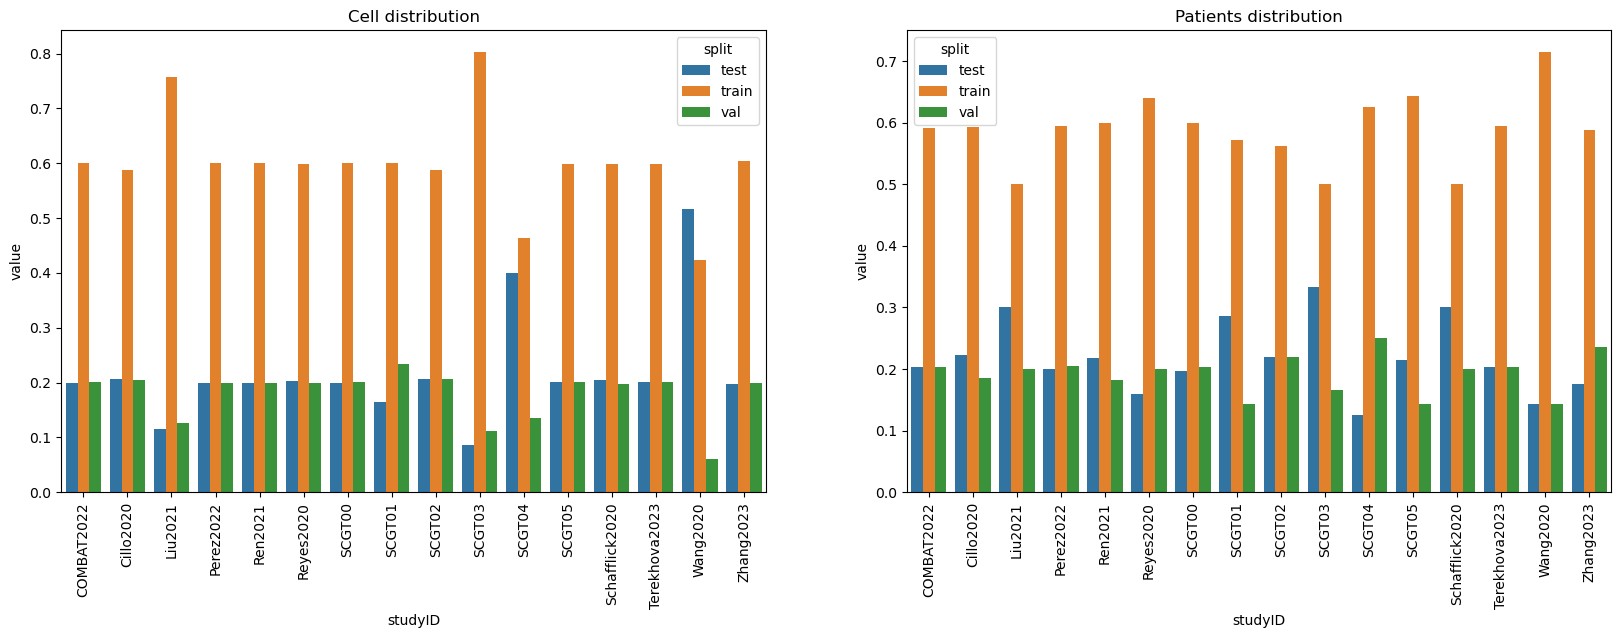

In [14]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=target_y, y='value', hue='split', data=cell_plot_data, ax=axs[0])
axs[0].set_title('Cell distribution')
axs[0].tick_params(axis='x', labelrotation=90)
sns.barplot(x=target_y, y='value', hue='split', data=pat_plot_data, ax=axs[1])
axs[1].set_title('Patients distribution')
axs[1].tick_params(axis='x', labelrotation=90)

os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/"), exist_ok=True)

plt.savefig(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/{RUN_NAME}{CELL_TYPE}_split_quality.pdf'), bbox_inches='tight', dpi=300)

In [15]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/"), exist_ok=True)

np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_train_idxs.npy"), train_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_val_idxs.npy"), val_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_test_idxs.npy"), test_idxs)

### SUBSET DATASET INTO TRAIN/TEST/VAL SPLITS

In [16]:
X_train = adata.X[train_idxs]
X_test = adata.X[test_idxs]
X_val = adata.X[val_idxs]
X_train.shape, X_test.shape, X_val.shape

((28149, 935), (9626, 935), (9301, 935))

In [17]:
y_train = adata.obs.iloc[train_idxs][target_y].values.astype(str)
y_test = adata.obs.iloc[test_idxs][target_y].values.astype(str)
y_val = adata.obs.iloc[val_idxs][target_y].values.astype(str)
y_train.shape, y_test.shape, y_val.shape 

((28149,), (9626,), (9301,))

In [18]:
lenc = LabelEncoder()
y_train_enc = lenc.fit_transform(y_train)
y_val_enc = lenc.transform(y_val)
y_test_enc = lenc.transform(y_test)

### GENERATE F1 

In [19]:
def custom_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred.argmax(1), average='weighted')

In [20]:
eval_metric=custom_f1_score
eval_metric_name='custom_f1_score'

def objective(trial):
    params = {
        'sampling_method': 'gradient_based',
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-{eval_metric_name}')
    xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        early_stopping_rounds=20,
        callbacks=[pruning_callback],
        **params
    )
    xgb.fit(
        X_train, 
        y_train_enc, 
        verbose=0,
        eval_set=[(X_val, y_val_enc)],
    )
    trial.set_user_attr('best_iteration', xgb.best_iteration)

    return xgb.best_score

In [21]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
wandb_kwargs = {"project": "xgboost", "name": f"{RUN_NAME}{CELL_TYPE}"}
wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[wandbc], gc_after_trial=True)

[I 2025-03-20 05:21:59,280] A new study created in memory with name: no-name-0923c5e5-55f2-4210-9145-5a049ed296bd


/tmp/ipykernel_2772740/350114600.py:4: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dav1989 (inflammation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.8


wandb: Run data is saved locally in /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/wandb/run-20250320_052203-btbp4a3o
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run studyID_DC


wandb: ⭐️ View project at https://wandb.ai/inflammation/xgboost


wandb: 🚀 View run at https://wandb.ai/inflammation/xgboost/runs/btbp4a3o


[I 2025-03-20 05:22:06,709] Trial 0 finished with value: -0.888225 and parameters: {'max_depth': 9, 'min_child_weight': 238, 'subsample': 0.7587945476302645, 'colsample_bynode': 0.6387926357773329, 'learning_rate': 0.0026368755339723046}. Best is trial 0 with value: -0.888225.


[I 2025-03-20 05:22:15,642] Trial 1 finished with value: -0.98939 and parameters: {'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8795585311974417, 'colsample_bynode': 0.6410035105688879, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: -0.98939.


[I 2025-03-20 05:23:02,917] Trial 2 finished with value: -0.969329 and parameters: {'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'learning_rate': 0.003095566460242371}. Best is trial 1 with value: -0.98939.


[I 2025-03-20 05:23:11,661] Trial 3 finished with value: -0.980994 and parameters: {'max_depth': 6, 'min_child_weight': 77, 'subsample': 0.5722807884690141, 'colsample_bynode': 0.48875051677790415, 'learning_rate': 0.006109683510122491}. Best is trial 1 with value: -0.98939.


[I 2025-03-20 05:23:20,189] Trial 4 finished with value: -0.987988 and parameters: {'max_depth': 14, 'min_child_weight': 35, 'subsample': 0.3629301836816964, 'colsample_bynode': 0.4297256589643226, 'learning_rate': 0.01701841881702917}. Best is trial 1 with value: -0.98939.


[I 2025-03-20 05:23:22,478] Trial 5 pruned. Trial was pruned at iteration 23.


[I 2025-03-20 05:23:25,080] Trial 6 finished with value: -0.988378 and parameters: {'max_depth': 13, 'min_child_weight': 43, 'subsample': 0.1585464336867516, 'colsample_bynode': 0.9539969835279999, 'learning_rate': 0.4038423798071558}. Best is trial 1 with value: -0.98939.


[I 2025-03-20 05:23:25,838] Trial 7 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:23:26,828] Trial 8 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:23:27,900] Trial 9 pruned. Trial was pruned at iteration 1.


[I 2025-03-20 05:23:33,360] Trial 10 finished with value: -0.989137 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9725833997090791, 'colsample_bynode': 0.11616568805333755, 'learning_rate': 0.17780618353487967}. Best is trial 1 with value: -0.98939.


[I 2025-03-20 05:23:40,582] Trial 11 finished with value: -0.989877 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.9818290990185045, 'colsample_bynode': 0.17702656156719, 'learning_rate': 0.11568531411766632}. Best is trial 11 with value: -0.989877.


[I 2025-03-20 05:23:50,326] Trial 12 finished with value: -0.989959 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9762317723681219, 'colsample_bynode': 0.14667845540225039, 'learning_rate': 0.07220195396446882}. Best is trial 12 with value: -0.989959.


[I 2025-03-20 05:23:51,088] Trial 13 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:23:52,016] Trial 14 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:23:53,486] Trial 15 pruned. Trial was pruned at iteration 4.


[I 2025-03-20 05:23:54,267] Trial 16 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:23:55,229] Trial 17 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:23:56,256] Trial 18 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:23:57,230] Trial 19 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:23:58,004] Trial 20 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:23:59,017] Trial 21 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:00,068] Trial 22 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:00,874] Trial 23 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:01,814] Trial 24 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:02,850] Trial 25 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:03,845] Trial 26 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:04,621] Trial 27 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:07,229] Trial 28 pruned. Trial was pruned at iteration 14.


[I 2025-03-20 05:24:08,056] Trial 29 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:09,037] Trial 30 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:10,550] Trial 31 pruned. Trial was pruned at iteration 4.


[I 2025-03-20 05:24:11,437] Trial 32 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:12,472] Trial 33 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:13,597] Trial 34 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:14,376] Trial 35 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:15,416] Trial 36 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:16,451] Trial 37 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:17,260] Trial 38 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:18,203] Trial 39 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:19,139] Trial 40 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:20,215] Trial 41 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:21,024] Trial 42 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:24,070] Trial 43 pruned. Trial was pruned at iteration 25.


[I 2025-03-20 05:24:28,540] Trial 44 finished with value: -0.988666 and parameters: {'max_depth': 11, 'min_child_weight': 21, 'subsample': 0.9619083969356736, 'colsample_bynode': 0.88799027860589, 'learning_rate': 0.22311917447306392}. Best is trial 12 with value: -0.989959.


[I 2025-03-20 05:24:29,334] Trial 45 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:30,317] Trial 46 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:31,303] Trial 47 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:32,347] Trial 48 pruned. Trial was pruned at iteration 0.


[I 2025-03-20 05:24:33,152] Trial 49 pruned. Trial was pruned at iteration 0.


In [22]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/"), exist_ok=True)

joblib.dump(study, here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/{RUN_NAME}{CELL_TYPE}_xgboost.pkl'))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/study/studyID_DC_xgboost.pkl']

In [23]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/"), exist_ok=True)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.write_image(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/{RUN_NAME}{CELL_TYPE}_pcoord.pdf'))

In [24]:
n_estimators = int(study.best_trial.user_attrs['best_iteration']*1.2)
xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        **study.best_trial.params
    )
xgb.fit(
    ssp.vstack((X_train, X_val)), 
    np.concatenate((y_train_enc, y_val_enc)), 
    eval_set=[(X_test, y_test_enc)],
    verbose=1,
)

[0]	validation_0-mlogloss:2.24593	validation_0-custom_f1_score:-0.96356


[1]	validation_0-mlogloss:1.93762	validation_0-custom_f1_score:-0.97291


[2]	validation_0-mlogloss:1.71390	validation_0-custom_f1_score:-0.97729


[3]	validation_0-mlogloss:1.53615	validation_0-custom_f1_score:-0.97937


[4]	validation_0-mlogloss:1.38895	validation_0-custom_f1_score:-0.98127


[5]	validation_0-mlogloss:1.26497	validation_0-custom_f1_score:-0.98256


[6]	validation_0-mlogloss:1.15804	validation_0-custom_f1_score:-0.98321


[7]	validation_0-mlogloss:1.06491	validation_0-custom_f1_score:-0.98286


[8]	validation_0-mlogloss:0.98189	validation_0-custom_f1_score:-0.98285


[9]	validation_0-mlogloss:0.90723	validation_0-custom_f1_score:-0.98309


[10]	validation_0-mlogloss:0.83963	validation_0-custom_f1_score:-0.98426


[11]	validation_0-mlogloss:0.77982	validation_0-custom_f1_score:-0.98403


[12]	validation_0-mlogloss:0.72458	validation_0-custom_f1_score:-0.98425


[13]	validation_0-mlogloss:0.67426	validation_0-custom_f1_score:-0.98437


[14]	validation_0-mlogloss:0.62911	validation_0-custom_f1_score:-0.98427


[15]	validation_0-mlogloss:0.58705	validation_0-custom_f1_score:-0.98438


[16]	validation_0-mlogloss:0.54832	validation_0-custom_f1_score:-0.98438


[17]	validation_0-mlogloss:0.51226	validation_0-custom_f1_score:-0.98481


[18]	validation_0-mlogloss:0.47931	validation_0-custom_f1_score:-0.98481


[19]	validation_0-mlogloss:0.44868	validation_0-custom_f1_score:-0.98513


[20]	validation_0-mlogloss:0.42049	validation_0-custom_f1_score:-0.98555


[21]	validation_0-mlogloss:0.39421	validation_0-custom_f1_score:-0.98556


[22]	validation_0-mlogloss:0.36930	validation_0-custom_f1_score:-0.98566


[23]	validation_0-mlogloss:0.34676	validation_0-custom_f1_score:-0.98546


[24]	validation_0-mlogloss:0.32612	validation_0-custom_f1_score:-0.98588


[25]	validation_0-mlogloss:0.30665	validation_0-custom_f1_score:-0.98609


[26]	validation_0-mlogloss:0.28842	validation_0-custom_f1_score:-0.98599


[27]	validation_0-mlogloss:0.27174	validation_0-custom_f1_score:-0.98588


[28]	validation_0-mlogloss:0.25619	validation_0-custom_f1_score:-0.98555


[29]	validation_0-mlogloss:0.24070	validation_0-custom_f1_score:-0.98555


[30]	validation_0-mlogloss:0.22711	validation_0-custom_f1_score:-0.98588


[31]	validation_0-mlogloss:0.21414	validation_0-custom_f1_score:-0.98588


[32]	validation_0-mlogloss:0.20243	validation_0-custom_f1_score:-0.98620


[33]	validation_0-mlogloss:0.19130	validation_0-custom_f1_score:-0.98620


[34]	validation_0-mlogloss:0.18087	validation_0-custom_f1_score:-0.98630


[35]	validation_0-mlogloss:0.17119	validation_0-custom_f1_score:-0.98620


[36]	validation_0-mlogloss:0.16218	validation_0-custom_f1_score:-0.98630


[37]	validation_0-mlogloss:0.15393	validation_0-custom_f1_score:-0.98630


[38]	validation_0-mlogloss:0.14578	validation_0-custom_f1_score:-0.98630


[39]	validation_0-mlogloss:0.13849	validation_0-custom_f1_score:-0.98630


[40]	validation_0-mlogloss:0.13158	validation_0-custom_f1_score:-0.98641


[41]	validation_0-mlogloss:0.12503	validation_0-custom_f1_score:-0.98630


[42]	validation_0-mlogloss:0.11873	validation_0-custom_f1_score:-0.98651


[43]	validation_0-mlogloss:0.11324	validation_0-custom_f1_score:-0.98651


[44]	validation_0-mlogloss:0.10828	validation_0-custom_f1_score:-0.98651


[45]	validation_0-mlogloss:0.10365	validation_0-custom_f1_score:-0.98661


[46]	validation_0-mlogloss:0.09911	validation_0-custom_f1_score:-0.98661


[47]	validation_0-mlogloss:0.09489	validation_0-custom_f1_score:-0.98651


[48]	validation_0-mlogloss:0.09096	validation_0-custom_f1_score:-0.98661


[49]	validation_0-mlogloss:0.08738	validation_0-custom_f1_score:-0.98672


[50]	validation_0-mlogloss:0.08358	validation_0-custom_f1_score:-0.98672


[51]	validation_0-mlogloss:0.08046	validation_0-custom_f1_score:-0.98661


[52]	validation_0-mlogloss:0.07749	validation_0-custom_f1_score:-0.98672


[53]	validation_0-mlogloss:0.07457	validation_0-custom_f1_score:-0.98683


[54]	validation_0-mlogloss:0.07216	validation_0-custom_f1_score:-0.98683


[55]	validation_0-mlogloss:0.06977	validation_0-custom_f1_score:-0.98672


[56]	validation_0-mlogloss:0.06778	validation_0-custom_f1_score:-0.98683


[57]	validation_0-mlogloss:0.06594	validation_0-custom_f1_score:-0.98683


[58]	validation_0-mlogloss:0.06359	validation_0-custom_f1_score:-0.98694


[59]	validation_0-mlogloss:0.06146	validation_0-custom_f1_score:-0.98683


[60]	validation_0-mlogloss:0.05984	validation_0-custom_f1_score:-0.98683


[61]	validation_0-mlogloss:0.05823	validation_0-custom_f1_score:-0.98683


[62]	validation_0-mlogloss:0.05656	validation_0-custom_f1_score:-0.98672


[63]	validation_0-mlogloss:0.05538	validation_0-custom_f1_score:-0.98672


[64]	validation_0-mlogloss:0.05428	validation_0-custom_f1_score:-0.98694


[65]	validation_0-mlogloss:0.05315	validation_0-custom_f1_score:-0.98683


[66]	validation_0-mlogloss:0.05205	validation_0-custom_f1_score:-0.98683


[67]	validation_0-mlogloss:0.05117	validation_0-custom_f1_score:-0.98683


[68]	validation_0-mlogloss:0.05030	validation_0-custom_f1_score:-0.98683

[69]	validation_0-mlogloss:0.04951	validation_0-custom_f1_score:-0.98683


[70]	validation_0-mlogloss:0.04849	validation_0-custom_f1_score:-0.98683


[71]	validation_0-mlogloss:0.04791	validation_0-custom_f1_score:-0.98683


[72]	validation_0-mlogloss:0.04719	validation_0-custom_f1_score:-0.98683


[73]	validation_0-mlogloss:0.04649	validation_0-custom_f1_score:-0.98683


[74]	validation_0-mlogloss:0.04605	validation_0-custom_f1_score:-0.98672


[75]	validation_0-mlogloss:0.04559	validation_0-custom_f1_score:-0.98672


[76]	validation_0-mlogloss:0.04510	validation_0-custom_f1_score:-0.98672

[77]	validation_0-mlogloss:0.04464	validation_0-custom_f1_score:-0.98672


[78]	validation_0-mlogloss:0.04414	validation_0-custom_f1_score:-0.98672


[79]	validation_0-mlogloss:0.04405	validation_0-custom_f1_score:-0.98672


[80]	validation_0-mlogloss:0.04347	validation_0-custom_f1_score:-0.98672


[81]	validation_0-mlogloss:0.04321	validation_0-custom_f1_score:-0.98672


[82]	validation_0-mlogloss:0.04281	validation_0-custom_f1_score:-0.98672


[83]	validation_0-mlogloss:0.04263	validation_0-custom_f1_score:-0.98672


[84]	validation_0-mlogloss:0.04216	validation_0-custom_f1_score:-0.98672


[85]	validation_0-mlogloss:0.04151	validation_0-custom_f1_score:-0.98683


[86]	validation_0-mlogloss:0.04125	validation_0-custom_f1_score:-0.98694


[87]	validation_0-mlogloss:0.04102	validation_0-custom_f1_score:-0.98694


[88]	validation_0-mlogloss:0.04100	validation_0-custom_f1_score:-0.98694


[89]	validation_0-mlogloss:0.04077	validation_0-custom_f1_score:-0.98694


[90]	validation_0-mlogloss:0.04079	validation_0-custom_f1_score:-0.98694


[91]	validation_0-mlogloss:0.04096	validation_0-custom_f1_score:-0.98694


[92]	validation_0-mlogloss:0.04079	validation_0-custom_f1_score:-0.98694


[93]	validation_0-mlogloss:0.04083	validation_0-custom_f1_score:-0.98694


[94]	validation_0-mlogloss:0.04085	validation_0-custom_f1_score:-0.98694


[95]	validation_0-mlogloss:0.04089	validation_0-custom_f1_score:-0.98694


[96]	validation_0-mlogloss:0.04070	validation_0-custom_f1_score:-0.98694


[97]	validation_0-mlogloss:0.04079	validation_0-custom_f1_score:-0.98694


[98]	validation_0-mlogloss:0.04054	validation_0-custom_f1_score:-0.98694


[99]	validation_0-mlogloss:0.04011	validation_0-custom_f1_score:-0.98694


[100]	validation_0-mlogloss:0.03981	validation_0-custom_f1_score:-0.98694


[101]	validation_0-mlogloss:0.03960	validation_0-custom_f1_score:-0.98694


[102]	validation_0-mlogloss:0.03940	validation_0-custom_f1_score:-0.98694


[103]	validation_0-mlogloss:0.03937	validation_0-custom_f1_score:-0.98694


[104]	validation_0-mlogloss:0.03914	validation_0-custom_f1_score:-0.98694


[105]	validation_0-mlogloss:0.03927	validation_0-custom_f1_score:-0.98694


[106]	validation_0-mlogloss:0.03911	validation_0-custom_f1_score:-0.98694


[107]	validation_0-mlogloss:0.03928	validation_0-custom_f1_score:-0.98694

[108]	validation_0-mlogloss:0.03958	validation_0-custom_f1_score:-0.98694


[109]	validation_0-mlogloss:0.03960	validation_0-custom_f1_score:-0.98683


[110]	validation_0-mlogloss:0.03938	validation_0-custom_f1_score:-0.98683


[111]	validation_0-mlogloss:0.03942	validation_0-custom_f1_score:-0.98683


[112]	validation_0-mlogloss:0.03922	validation_0-custom_f1_score:-0.98683


[113]	validation_0-mlogloss:0.03928	validation_0-custom_f1_score:-0.98683


[114]	validation_0-mlogloss:0.03957	validation_0-custom_f1_score:-0.98683


[115]	validation_0-mlogloss:0.03951	validation_0-custom_f1_score:-0.98683


[116]	validation_0-mlogloss:0.03944	validation_0-custom_f1_score:-0.98683


[117]	validation_0-mlogloss:0.03962	validation_0-custom_f1_score:-0.98683


[118]	validation_0-mlogloss:0.03962	validation_0-custom_f1_score:-0.98683


[119]	validation_0-mlogloss:0.03949	validation_0-custom_f1_score:-0.98683


[120]	validation_0-mlogloss:0.03925	validation_0-custom_f1_score:-0.98683


[121]	validation_0-mlogloss:0.03953	validation_0-custom_f1_score:-0.98683


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.14667845540225039,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function custom_f1_score at 0x7cc1801b3060>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07220195396446882, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=122, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/"), exist_ok=True)

joblib.dump(xgb, (here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/{RUN_NAME}{CELL_TYPE}_xgb.json')))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/best_model/studyID_DC_xgb.json']

In [26]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/"), exist_ok=True)

(pd.DataFrame(np.array((y_test, y_test_enc, xgb.predict(X_test))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_test.zip')))
(pd.DataFrame(np.array((y_train, y_train_enc, xgb.predict(X_train))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_train.zip')))

/scratch_isilon/groups/singlecell/shared/conda_env/xgboostGPU/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[05:24:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


